<a href="https://colab.research.google.com/github/SuyashMore/tinyNeuralNet/blob/master/tinyNN-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

#Activation Functions

In [3]:
#Activation Functions

#'der' refers to Derivative of the corresponding Function - X is the Cached Value of Activation Function
def activation_sigmoid(X,der=False):
    if not der:
        return np.divide(1, 1 + np.exp(-X) )
    else:
        return np.multiply(X,(1-X))

def activation_linear(X,der=False):
    if not der:
        return X
    else:
        return np.ones(X.shape)


def activation_relu(X,der=False):
    if not der:
        return np.maximum(0,X)
    else:
        return (X>=0).astype(float)

def activation_softmax(X,der=False):
    if not der:
        expp = np.exp(X-np.max(X,axis=0))
        denum = np.sum(expp,axis=0)
        res = np.divide(expp,denum)
        return res
    else:
        print("Something is Wrong")
        pass



#Cost Function

In [4]:
#Cost Functions
def crossEntropyCost(Y,Y_orig,der=False):
    if not der:
        m=Y.shape[1]
        costMat = Y_orig*np.log(Y)+(1-Y_orig)*np.log(1-Y)
        print(f"Cost Mat:\n{costMat}")
        cost = -np.sum(costMat)/m
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        return cost
    else:
        dLda = -(np.divide(Y_orig, Y) - np.divide(1 - Y_orig, 1 - Y))  
        return dLda


def cross_entropy(Y, Y_orig, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(Y, epsilon, 1. - epsilon)
    N = Y.shape[0]
    ce = -np.sum(Y_orig*np.log(Y+1e-9))/N
    return ce


#Neural Network Class

In [18]:
class NeuralNetwork():
    def __init__(self):
        self.layerSizes = []
        self.activations = []

    def debugPrint(self,x):
        if self.debug:
            print(x)

    def init_adam(self,beta1 = 0.9,beta2=0.999):
        #Adam Optimizer Terms
        self.v = [None]*self.totalLayers #Momentum
        self.s = [None]*self.totalLayers #RMSProp
        self.v_corrected = [None]*self.totalLayers #Momentum
        self.s_corrected = [None]*self.totalLayers #RMSProp

        self.beta1 = beta1
        self.beta2 = beta2

        for i in range (self.totalLayers):

            # Dimensions of Weight Matrix : (layer i+1 , layer i),Bias:(layer i,1)
            self.v[i]=np.zeros(self.weights[i].shape)
            self.s[i]=np.zeros(self.weights[i].shape)
            self.v_corrected[i]=np.zeros(self.weights[i].shape)
            self.s_corrected[i]=np.zeros(self.weights[i].shape)
            


    def compile(self,lr=0.9,debug=False):

        self.debug=debug
        self.lr = lr

        # Initialize Empty Arrays to Store Weights and Biases
        self.totalLayers = len(self.layerSizes)-1
        self.weights = [None]*self.totalLayers
        self.bias = [None]*self.totalLayers

        

        # Initialize Weight and Bias Matrix 
        for i in range (len(self.layerSizes)-1):

            # Dimensions of Weight Matrix : (layer i+1 , layer i),Bias:(layer i,1)

            #He Random Initialization
            self.weights[i]=np.random.random((self.layerSizes[i+1],self.layerSizes[i]))*((2/(self.layerSizes[i]))**0.5)
            self.bias[i]=np.random.random((self.layerSizes[i+1],1))*0.1
            
            assert(self.weights[i].shape==(self.layerSizes[i+1],self.layerSizes[i]))
            assert(self.bias[i].shape==(self.layerSizes[i+1],1))

        
        print("Model Compiled Successfully")

    def addLayer(self,layerSize,activation=None):
        self.layerSizes.append(layerSize)

        if len(self.layerSizes)==1: # No Activation on Input Layer
            assert(activation==None) 
        else:
            assert(activation!=None) # Activation Required
            self.activations.append(activation)

    
    def forward(self,X):
        Z = None
        A = X
        self.activationCache = [] # Used to Compute Gradients

        self.debugPrint("=================Model Meta=====================")
        self.debugPrint(f"Layers(Including Input) :{self.layerSizes}")
        self.debugPrint(f"Activations:{self.activations}")
        self.activationCache.append(X)
        # Forward Propogate through Each Layer
        for i in range(self.totalLayers):
            Z = np.dot(self.weights[i],A)+self.bias[i] # Z= W.X + b
            
            A = self.activations[i](Z)                  # A = activation(Z)
            self.activationCache.append(A)

            self.debugPrint("======================================================")
            self.debugPrint(f"Layer #{i+1} Output:\n{A}")
            self.debugPrint(f"Layer Weights:\{self.weights[i]}")
            self.debugPrint(f"Layer Bias:\{self.bias[i]}")
        self.debugPrint("================== End Of Model =================================")
        self.last_Output = A
        return A


    def fit(self,X,Y,epochs=1):
        # Feed Forward
        self.init_adam()

        result = self.forward(X)
        
        #Compute Cost
        cost = cross_entropy(result,Y)
        print(f"Initial Cost:{cost}")

        for i in range(epochs):
            # Feed Forward
            # result = self.forward(X)

            #Compute Gradients
            dWs,dbs = self.compute_grads(Y,result)

            #Apply Gradients
            self.apply_grads_adam(dWs,dbs,i+1)

            # Compute Cost
            result = self.forward(X)

            cost = cross_entropy(result,Y)

            # print(f"Result:\n{result} \n Y:\n{Y}  \n cost:{cost}")

            print(f"Epoch ({i}/{epochs-1})=> Cost:{cost}")



    #Use Standard Gradient Descent
    def apply_grads(self,dWs,dbs,t):

        for i in range(self.totalLayers):
            self.weights[i] -= self.lr * dWs[i]
            self.bias[i] -= self.lr * dbs[i]

    # Used Adam Optimizer
    def apply_grads_adam(self,dWs,dbs,t):
        
        for i in range(self.totalLayers):
            self.v[i]= self.beta1*self.v[i]+(1-self.beta1)*dWs[i]
            self.v_corrected[i]= np.divide(self.v[i],(1-self.beta1**t))
            # print(f"V-corrected:\n{self.v_corrected[i]}")
            # self.s[i]= self.beta2*self.s[i]+(1-self.beta2)*np.power(dWs[i],2)
            # self.s_corrected[i]= np.divide(self.s[i],(1-self.beta2**t))

            numerator=self.v_corrected[i]
            # denum = np.power(self.s[i],0.5)+1e-8

            # Currently use only Momentum
            dW_adam = np.divide(numerator,1)
            # dW_adam = self.v[i]
            # print(f"Dw_adam:\n{dW_adam}")

            # print(f"Dw_adam:\n{dW_adam}")
            self.weights[i] -= self.lr * dW_adam
            self.bias[i] -= self.lr * dbs[i]



    def compute_grads(self,Y,result): # Returns Cost and Grads(dws,dbs)

        def linear_backward(dZ,cached_activation,weights,bias): #Calculate grads for Layer i
            #cached_activation(activation in layer i),weights(weight Matrix of ith layer),bias(bias matrix of ith layer)
            m=cached_activation.shape[1] #For Vetorized Implementation
            # print(f"dZ = {dZ}")
            # print(f"Cached Act:{cached_activation}")
            dW = np.dot(dZ,cached_activation.T)/m
            db = np.sum(dZ,axis=1,keepdims=True)
            dA = np.dot(weights.T,dZ)
            # print(f"dW = {dW}")

            assert (dW.shape == weights.shape)
            assert (db.shape == bias.shape)
            assert (dA.shape == cached_activation.shape)
            

            return (dW,db,dA)

        
        # dLda = cross_entropy(self.last_Output,Y,der=True)


        dZs = [None]*self.totalLayers
        dWs = [None]*self.totalLayers
        dbs = [None]*self.totalLayers
        

        # dZs[-1]=dLda
        dldz=None
        dadz=None
        layer_cache=None
        # print(f"dZs:{dZs}")
        for l in reversed(range(self.totalLayers)):
            # print(f"Layer #{l} ")
            if l==(self.totalLayers-1):
                dldz = result-Y
                layer_cache = self.activationCache[l]
            else:
                dadz = self.activations[l](self.activationCache[l+1],der=True)
                layer_cache = self.activationCache[l]
                dldz = np.multiply(dZs[l],dadz)
            dw,db,dA = linear_backward(dldz,layer_cache,self.weights[l],self.bias[l])
            dZs[l-1]=dA
            dWs[l]=dw
            dbs[l]=db

        return dWs,dbs











#Sample Initialization

In [19]:
nn = NeuralNetwork()
nn.addLayer(2)
nn.addLayer(6,activation_sigmoid)
nn.addLayer(6,activation_sigmoid)
nn.addLayer(6,activation_sigmoid)
nn.addLayer(3,activation_softmax)
nn.compile(lr=1)

X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0,0,1],[0,1,0],[1,0,0],[0,1,0]])

# print(f"Input:{X}")
res = nn.forward(X.T)
# print(f"result:{res}")

# print(f"Target:{Y}")

nn.fit(X.T,Y.T,5)

Model Compiled Successfully
Initial Cost:1.7144585715922158
Epoch (0/4)=> Cost:2.01818628957774
Epoch (1/4)=> Cost:1.516992896911525
Epoch (2/4)=> Cost:1.4332691272256595
Epoch (3/4)=> Cost:1.401035729931392
Epoch (4/4)=> Cost:1.3886854509642486


#Forward pass

In [21]:
print(nn.forward(np.array([[1,0]]).T))

[[0.2279736 ]
 [0.54401384]
 [0.22801256]]


#Load MNIST DataSet(from keras.datasets) and Preprocess the data

In [22]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train_cp = X_train.copy()

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

examples = 1000

X_train_orig = X_train
X_train = X_train[:examples,:]

# X_test = 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)


# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)
Y_train_orig = Y_train
Y_train = Y_train[:examples,:]

print(f"Xdmis:{X_train.shape}")
print(f"Ydmis:{Y_train.shape}")

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (1000, 784)
Test matrix shape (10000, 784)
Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)
Xdmis:(1000, 784)
Ydmis:(1000, 10)


#Test Neural Network Architecture

In [23]:
model = NeuralNetwork()
#784 input image pixels
model.addLayer(784) 
#512 hidden neurons
model.addLayer(512,activation_sigmoid) 
# 10 output neutons with softmax classifier (0-9 digits)
model.addLayer(10,activation_softmax)

#Learning Rate = 0.2
model.compile(lr=0.2)

Model Compiled Successfully


Train the Neural Network for 2000 epochs

In [24]:
# res = model.forward(X_train.T)
# print(f"Result:{res}")
model.fit(X_train.T,Y_train.T,2000)

Initial Cost:243.26988073015545
Epoch (0/1999)=> Cost:1105.6309763515055
Epoch (1/1999)=> Cost:1121.995654438094
Epoch (2/1999)=> Cost:1355.3065795623138
Epoch (3/1999)=> Cost:1839.43264587542
Epoch (4/1999)=> Cost:1787.7089977424712
Epoch (5/1999)=> Cost:1570.5083051861657
Epoch (6/1999)=> Cost:1746.6055257697492
Epoch (7/1999)=> Cost:1831.9366999248882
Epoch (8/1999)=> Cost:1667.095923507913
Epoch (9/1999)=> Cost:1702.152185134018
Epoch (10/1999)=> Cost:1685.3858123143036
Epoch (11/1999)=> Cost:1892.0341709045074
Epoch (12/1999)=> Cost:1837.7042199356445
Epoch (13/1999)=> Cost:1611.3671809346222
Epoch (14/1999)=> Cost:1663.1999966293952
Epoch (15/1999)=> Cost:1817.5033567852902
Epoch (16/1999)=> Cost:1823.7538393958196
Epoch (17/1999)=> Cost:1465.093095197572
Epoch (18/1999)=> Cost:1783.527320817361
Epoch (19/1999)=> Cost:1685.1817452081189
Epoch (20/1999)=> Cost:1815.4898465984413
Epoch (21/1999)=> Cost:1797.285237840144
Epoch (22/1999)=> Cost:1877.5278848178357
Epoch (23/1999)=> Co

#Import Visualization Tools

In [25]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt


#Test Trained Network on Image

In [26]:
predictId = 100
print(f"Target:{np.argmax(Y_train[predictId,:])}")
inputx = np.reshape(X_train[predictId,:].T,(784,1))
# print(f"InputX:{inputx.shape}")
res = np.argmax(model.forward(inputx))
print(f"result:{res}")



Target:5
result:5


result:3


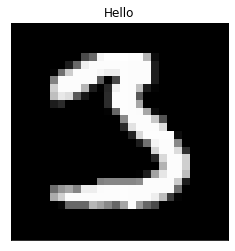

In [27]:
predictId = 11111
# print(f"Target:{np.argmax(Y_train[predictId,:])}")
inputx = np.reshape(X_train_orig[predictId,:].T,(784,1))
# print(f"InputX:{inputx.shape}")
res = np.argmax(model.forward(inputx))
print(f"result:{res}")

fig = plt.figure()
plt.imshow(X_train_cp[predictId], cmap='gray', interpolation='none')
plt.title("Hello")
plt.xticks([])
plt.yticks([])
fig

#Compute Total Correct Classes

In [ ]:
correct = 0
for i in range(40000,42000):
    target = np.argmax(Y_train_orig[predictId,:])
    # print(f"Target:{}")
    inputx = np.reshape(X_train_orig[predictId,:].T,(784,1))
    # print(f"InputX:{inputx.shape}")
    res = np.argmax(model.forward(inputx))
    # print(f"result:{res}")
    if target==res:
        correct+=1

print(f"Corrects:{correct}")
